<a href="https://colab.research.google.com/github/swat90/OIBSIP/blob/main/espam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Email spam detector**
Task objective : use machine learning to train the spam detector to recognize and classify emails into spam and non-spam


In [133]:
import pandas as pd
import re
import nltk
import string
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score , confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
import plotly.express as px

In [105]:
#load the dataset
espam = pd.read_csv(r"/content/drive/MyDrive/OASIS/spam.csv", encoding='latin1')
espam.info()
print(espam.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4  

In [106]:
#Remove last three unnecessary columns
espam = espam.drop(['Unnamed: 2','Unnamed: 3', 'Unnamed: 4'], axis = 1)
espam.info() #2 columns, 5572 entries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [107]:
# Rename the columns name
espam.rename(columns = {'v1': 'target', 'v2': 'text'}, inplace = True)

In [108]:
#Check for any duplicates
dupli = espam.duplicated().sum()
print(dupli)
#remove the duplicates
espam1 = espam.drop_duplicates(keep = 'first')
espam1.info() #5169 entries remaining

403
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  5169 non-null   object
 1   text    5169 non-null   object
dtypes: object(2)
memory usage: 121.1+ KB


In [109]:
#check for missing values
espam1.isnull().sum() #no missing values

target    0
text      0
dtype: int64

In [110]:
#check for individual counts, ham and spam
espam1['target'].value_counts()

ham     4516
spam     653
Name: target, dtype: int64

Distribution of Ham and Spam

In [111]:
# Data to Plot
count_Class = espam1['target'].value_counts()

labels = ['ham', 'spam']
sizes = [count_Class[0], count_Class[1]]
colors = ['green', 'red']

# Create a DataFrame for the pie plot
pie_data = pd.DataFrame({'labels': labels, 'sizes': sizes, 'colors': colors})

# Plot
fig = px.pie(pie_data, names='labels', values='sizes', color='colors',
             title='Distribution of Ham and Spam',
             color_discrete_map={'green': 'green', 'red': 'red'})

# Show the plot
fig.show()



In [112]:
# adding new column as length of the text
espam['length'] = espam['text'].apply(len)
espam.head()

,target,text,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Text(0.5, 1.0, 'Length of Text')

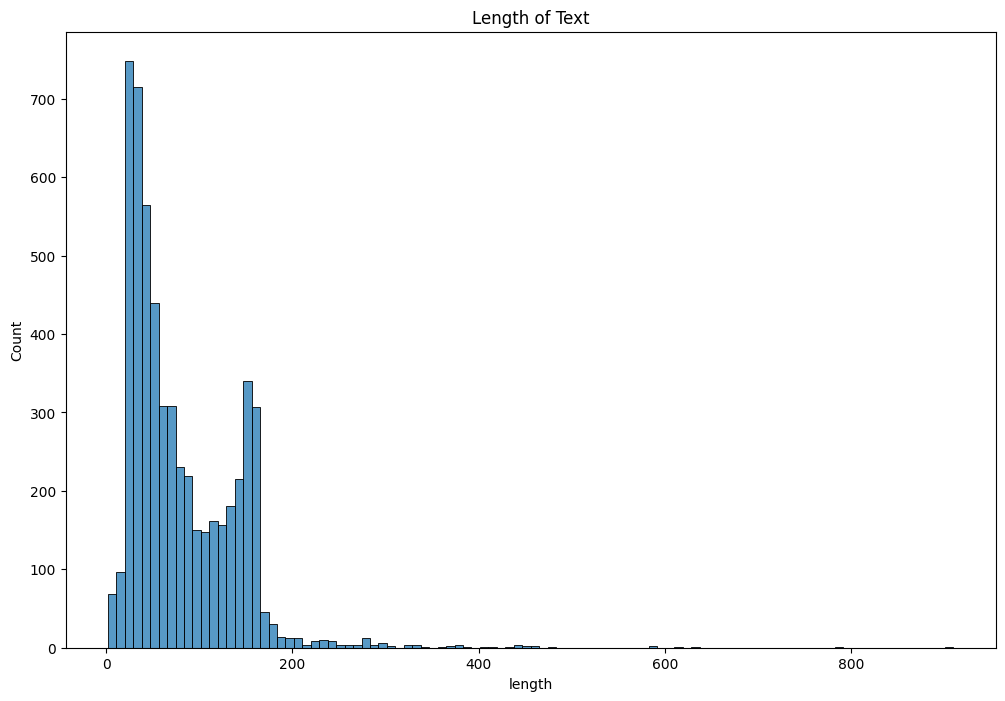

In [113]:
# Plot for distribution lenth of text
plt.figure(figsize=(12,8))
sns.histplot(x='length',data=espam,bins=100)
plt.title('Length of Text')
#positively skewed, most of the email have word length in the range of 0 to 200.

array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

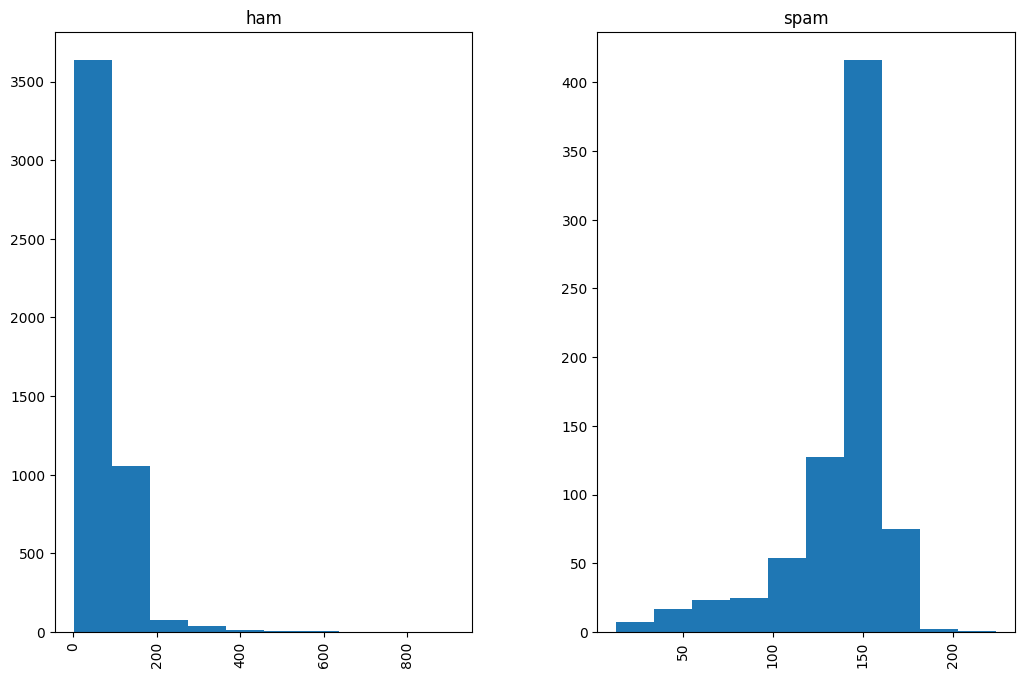

In [114]:
# distribution of spam and ham by length of text
espam.hist(column='length',by='target',figsize=(12,8))



1. Most of Ham mails have word length in the range of 0 to 200
2. Most of spam mails have word length around 150.



In [115]:
#chnage the lables to 0 and 1
espam['target'] = espam['target'].map({'ham' : 0, 'spam' : 1})

Split the data into train and test datasets

In [116]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(espam['text'], espam['target'], test_size=0.25, random_state=1)

Use CountVectorizer to convert a collection of text documents to a matrix of token counts.

In [117]:
count_vector = CountVectorizer()
train_data = count_vector.fit_transform(X_train)
test_data = count_vector.transform(X_test)

Multinomial Naive Bayes

In [118]:
Mnb = MultinomialNB()
Mnb.fit(train_data, y_train)
MnbPredicts = Mnb.predict(test_data)

In [119]:
print("The accuracy of our Naïve Bayes multinomial model is {} %".format(accuracy_score(y_test, MnbPredicts) * 100))
print("The Precision of our Naïve Bayes multinomial model is {} %". format(precision_score(y_test, MnbPredicts)* 100))
print("The Recall of our Naïve Bayes multinomial model is {} %" . format(recall_score(y_test, MnbPredicts)* 100))

The accuracy of our Naïve Bayes multinomial model is 98.56424982053123 %
The Precision of our Naïve Bayes multinomial model is 95.45454545454545 %
The Recall of our Naïve Bayes multinomial model is 93.33333333333333 %



 [[1205    8]
 [  12  168]]


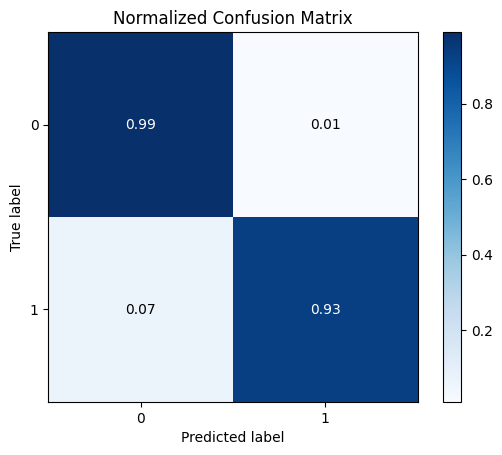

In [120]:
confusionmatrix = confusion_matrix(y_test, MnbPredicts)
print("\n", confusionmatrix)
skplt.metrics.plot_confusion_matrix(y_test, MnbPredicts, normalize = True)
plt.show()

Let's try with another approach and remove sop words and use TfidfTransformer with CountVectorizer

In [121]:
# function to remove punctuation and stopwords
nltk.download('stopwords')

def text_process(text):
    non_punc = [char for char in text if char not in string.punctuation]
    non_punc=''.join(non_punc)
    return [word for word in non_punc.split() if word not in stopwords.words('english')]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [122]:
# creating a pipline to model the data
# pipeline for MultinomialNB
pipe_mnb = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

# pipeline for Random Forest Classifier
pipe_rf =Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
])

#pipeline for svc
pipe_svc =Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tf',TfidfTransformer()),
    ('classifier',SVC())
])

In [128]:
# fit and predict the data
pipe_mnb.fit(X_train,y_train)
pred_mnb = pipe_mnb.predict(X_test)

In [129]:
pipe_rf.fit(X_train,y_train)
pred_rf = pipe_rf.predict(X_test)

In [130]:
pipe_svc.fit(X_train,y_train)
pred_svc = pipe_svc.predict(X_test)

In [131]:
# print confusion matrix and classification report
print ('Classification report on MultinomialNB:')
print('\n')
print(classification_report(y_test,pred_mnb))

print('---------------------------------------')

print ('Classification report on Random_forest_Classifier:')
print('\n')
print(classification_report(y_test,pred_rf))

print('---------------------------------------')

print ('Classification report on SVC:')
print('\n')
print(classification_report(y_test,pred_svc))

Classification report on MultinomialNB:


              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1213
           1       1.00      0.74      0.85       180

    accuracy                           0.97      1393
   macro avg       0.98      0.87      0.92      1393
weighted avg       0.97      0.97      0.96      1393

---------------------------------------
Classification report on Random_forest_Classifier:


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1213
           1       0.99      0.83      0.91       180

    accuracy                           0.98      1393
   macro avg       0.98      0.92      0.95      1393
weighted avg       0.98      0.98      0.98      1393

---------------------------------------
Classification report on SVC:


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1213
           1       1.00      0

In [137]:
print('The accuracy for Naïve Bayes multinomial Classifer:',accuracy_score(y_test,pred_mnb)*100)
print('The accuracy for Random_forest Classifer:',accuracy_score(y_test,pred_rf)*100)
print('The accuracy for SVC:',accuracy_score(y_test,pred_svc)*100)

The accuracy for Naïve Bayes multinomial Classifer: 96.62598707824839
The accuracy for Random_forest Classifer: 97.77458722182341
The accuracy for SVC: 97.77458722182341


The highest accuracy was for SVC classifier and Random Forest Classifier. Lets perform cross-validation for assessing the performance of both the models. The accuracy for Naïve Bayes multinomial is reduced after adding stop words and TfidfTransformer.

In [134]:
# Number of folds
k = 5

# Initialize the SVC model in the pipeline
pipe_svc.set_params(classifier=RandomForestClassifier())

# Perform k-fold cross-validation
cv_scores = cross_val_score(pipe_rf, espam['text'], espam['target'], cv=k)

# Output the results
print(f'CV Scores for each fold: {cv_scores}')
print(f'Average CV Score: {np.mean(cv_scores)}')

CV Scores for each fold: [0.97040359 0.96860987 0.96858169 0.96409336 0.97396768]
Average CV Score: 0.9691312363639291


In [135]:
# Initialize the SVC model in the pipeline
pipe_svc.set_params(classifier=SVC())

# Perform k-fold cross-validation
cv_scores = cross_val_score(pipe_svc, espam['text'], espam['target'], cv=k)

# Output the results
print(f'CV Scores for each fold: {cv_scores}')
print(f'Average CV Score: {np.mean(cv_scores)}')

CV Scores for each fold: [0.97668161 0.97130045 0.97217235 0.96858169 0.97845601]
Average CV Score: 0.9734384233280468


The average score for SVC is higher than Random forest. We will choose SVC as our final model to perform email spam detection.

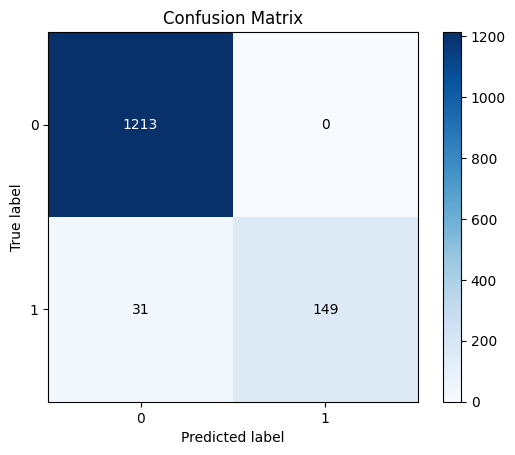

In [141]:
#Confusion  matrix for SVC
skplt.metrics.plot_confusion_matrix(y_test, pred_svc)
plt.show()
#31 mails which were Spam but actually predicted as Ham